# Stimulus selectivity

As a selectivity index we will use the sparseness metric defined in

*Vinje WE, Gallant JL (2000) Sparse coding and decorrelation in primary visual cortex during natural vision. Science 287:1273–1276*

$SI = (1 - \frac{E(Z)^2}{E(Z^2)}) / (1 - \frac{1}{n})$ 

Where $E(Z)$ is the expected value of the response strength over all stimuli, and $E(Z^2)$ is the expected value of the squared response strength over all stimuli.


In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import pprint
pp = pprint.PrettyPrinter(indent=4)

from soundsig.sound import spectrogram, plot_spectrogram

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

import groups
from analysis import (
    Auditory,
    fit_kde,
    get_stimulus_timeseries,
    ResponseStrength as RS,
)
from load_data import (
    load_spike_data,
    load_stim_data,
    load_auditory_info,
    load_ephys_stimulus, 
    load_rendition_data,
    load_unit_waveforms
)
from stats import jackknife, false_discovery
from utils import Colors, clean_spike_times
from plotting import fig_grid, border, plot_raster

%load_ext autoreload
%autoreload 2

In [2]:
ephys_data = load_spike_data()

In [3]:
rendition_data = load_rendition_data()

In [4]:
stim_data = load_stim_data()

In [5]:
unit_summary = load_auditory_info()

In [6]:
good_units = unit_summary[
    (unit_summary["snr"] > 5)
    & (unit_summary["isi_violation_pct"] < 0.001)
    & (unit_summary["n_trials"] > 8)
]

## Selectivity index

$SI = max_{RS}(all\ stims) / mean_{RS}(all\ stims)$

Alternate way of looking at selectivity is

$SI = p(stim\ elicits\ response) = len(auditory\ responses) / len(all\ responses)$

In [7]:
def selectivity_stats(unit_df):
    splits = [groups.all, groups.songs, groups.dcs, groups.ripples]
    result = {}
    for split in splits:
        subdf = split(unit_df)
        result[split.__name__] = {
            "rate": Auditory.selectivity_index(
                subdf,
                mode="rate",
                time_window=(0, 0.5)
            ),
            "max_response": Auditory.selectivity_index(
                subdf,
                mode="max_response",
                stim_duration=2.5
            ),
        }
    return result


def selectivity_rows(unit_df):
    splits = [groups.all, groups.songs, groups.dcs, groups.ripples]
    result = {}
    for split in splits:
        subdf = split(unit_df)
        result[split.__name__] = {
            "rate": Auditory.stim_responses(
                subdf,
                mode="rate",
                time_window=(0, 0.5)
            ),
            "max_response": Auditory.stim_responses(
                subdf,
                mode="max_response",
                stim_duration=2.5
            )
        }
    return result

### Print the selectivity indexes and selectivity of some example units I found

nonauditory = "e1u16sGreBla7410M_200116_090628"

auditory = "e0u47sWhiRed9510F_191220_170251"

sparse and precise = "e10u141sGreBla5671F_200117_080630"

tonic and auditory = "e27u25sGreBla7410M_200116_174224"

In [8]:
def plot_response_strengths(example):
    rows = selectivity_rows(example)
    for category in ["songs", "dcs", "ripples", "all"]:
        fig = plt.figure(figsize=(3, 1))
        plt.bar(
            np.arange(len(rows[category]["rate"])),
            rows[category]["rate"],
            width=0.3,
            label="{} onset rate (500ms)".format(category)
        )
        plt.bar(
            np.arange(len(rows[category]["max_response"])) + 0.3,
            rows[category]["max_response"],
            width=0.3,
            label="{} max response".format(category)
        )
        plt.legend(loc=(1, 0))
        plt.show()
        plt.close(fig)

In [9]:
example0 = ephys_data.query("unit_id == 'e1u16sGreBla7410M_200116_090628'")
example1 = ephys_data.query("unit_id == 'e0u47sWhiRed9510F_191220_170251'")
example2 = ephys_data.query("unit_id == 'e10u141sGreBla5671F_200117_080630'")
example3 = ephys_data.query("unit_id == 'e27u25sGreBla7410M_200116_174224'")


{   'all': {'max_response': 0.021986056245024133, 'rate': 0.051792893130459323},
    'dcs': {'max_response': 0.023900432908380582, 'rate': 0.05798197258402564},
    'ripples': {   'max_response': 0.007602989941043963,
                   'rate': 0.06475289223548995},
    'songs': {'max_response': 0.02165913162329783, 'rate': 0.04069980638447879}}


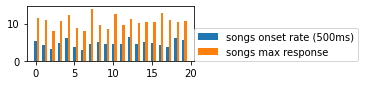

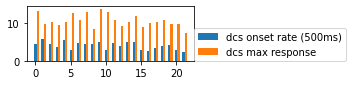

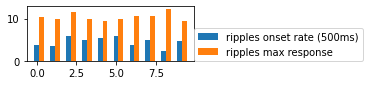

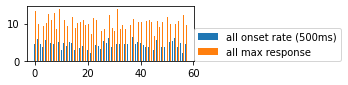

In [10]:
pp.pprint(selectivity_stats(example0))
plot_response_strengths(example0)

{   'all': {'max_response': 0.11367191585015, 'rate': 0.2852888461714612},
    'dcs': {'max_response': 0.09578464192915459, 'rate': 0.2257388315711158},
    'ripples': {   'max_response': 0.06400717080847576,
                   'rate': 0.19904214559386957},
    'songs': {'max_response': 0.15297597707701205, 'rate': 0.32625095774149826}}


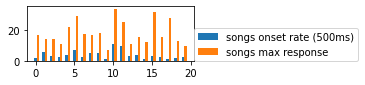

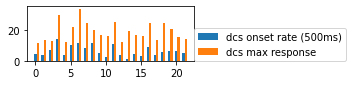

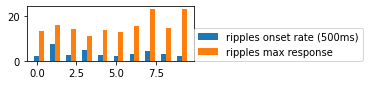

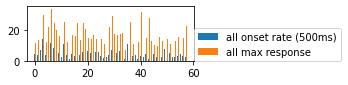

In [11]:
pp.pprint(selectivity_stats(example1))
plot_response_strengths(example1)

{   'all': {'max_response': 0.3914191497503155, 'rate': 0.5510461848802283},
    'dcs': {'max_response': 0.3466599150365835, 'rate': 0.40336658381063273},
    'ripples': {   'max_response': 0.13143987794324327,
                   'rate': 0.33542384791497737},
    'songs': {'max_response': 0.4161669244867825, 'rate': 0.5599238780154913}}


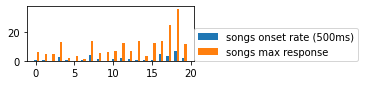

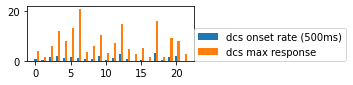

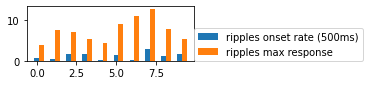

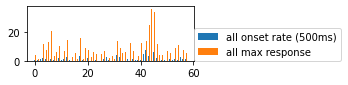

In [12]:
pp.pprint(selectivity_stats(example2))
plot_response_strengths(example2)

{   'all': {'max_response': 0.09434907613704777, 'rate': 0.09455900024032686},
    'dcs': {'max_response': 0.04528112818393596, 'rate': 0.06619230067505896},
    'ripples': {   'max_response': 0.05588345765370286,
                   'rate': 0.07004647232784106},
    'songs': {'max_response': 0.09916464239354573, 'rate': 0.132150165506794}}


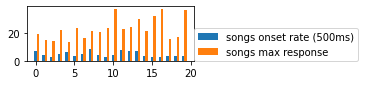

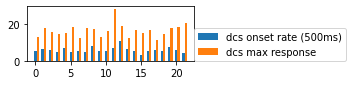

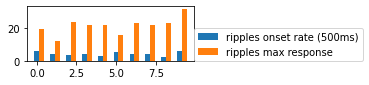

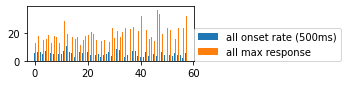

In [13]:
pp.pprint(selectivity_stats(example3))
plot_response_strengths(example3)

## Plot distribution of selectivity indexes

In [14]:
selectivity_results = []
for i in tqdm.tqdm_notebook(range(len(good_units))):
    row = good_units.iloc[i]
    unit_df = ephys_data.query("unit_id == '{}'".format(row.name))
    selectivity_results.append(selectivity_stats(unit_df))

/auto/fhome/kevin/Projects/zebra-finch-memory-lesions/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


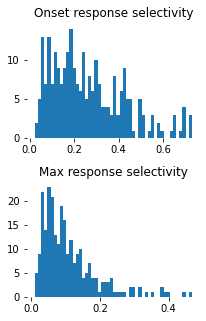

In [15]:
fig, axes = fig_grid(2, columns=1, ypad=0.1)

axes[0].hist([np.max(r["all"]["rate"]) for r in selectivity_results], bins=50)
border(axes[0])
axes[0].set_title("Onset response selectivity")

axes[1].hist([np.max(r["all"]["max_response"]) for r in selectivity_results], bins=50)
border(axes[1])
axes[1].set_title("Max response selectivity")

# axes[0].vlines([2.75, 4], *axes[0].get_ylim(), linestyle="--")
# axes[1].vlines([2, 2.5], *axes[1].get_ylim(), linestyle="--")
plt.show()
plt.close(fig)

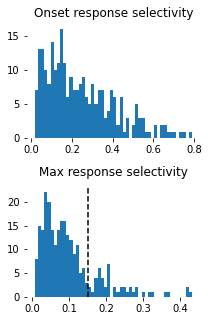

In [16]:
fig, axes = fig_grid(2, columns=1, ypad=0.1)

axes[0].hist([np.max(r["songs"]["rate"]) for r in selectivity_results], bins=50)
border(axes[0])
axes[0].set_title("Onset response selectivity")

axes[1].hist([np.max(r["songs"]["max_response"]) for r in selectivity_results], bins=50)
border(axes[1])
axes[1].set_title("Max response selectivity")

axes[1].vlines([0.15], *axes[1].get_ylim(), linestyle="--")

plt.show()
plt.close(fig)

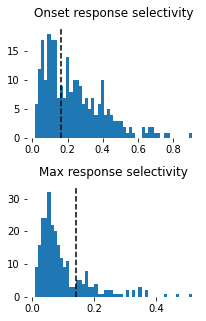

In [17]:
fig, axes = fig_grid(2, columns=1, ypad=0.1)

axes[0].hist([np.max(r["dcs"]["rate"]) for r in selectivity_results], bins=50)
border(axes[0])
axes[0].set_title("Onset response selectivity")

axes[1].hist([np.max(r["dcs"]["max_response"]) for r in selectivity_results], bins=50)
border(axes[1])
axes[1].set_title("Max response selectivity")

axes[0].vlines([0.16], *axes[0].get_ylim(), linestyle="--")
axes[1].vlines([0.14], *axes[1].get_ylim(), linestyle="--")
plt.show()
plt.close(fig)

In [18]:
def plot_audio_overlay(row, ax=None):
    if ax is None:
        ax = plt.gca()
    t_stim, stim = get_stimulus_timeseries(row["stimulus_file"], time_range=(-1.0, row["stim_duration"] + 1.0))
    ax.plot(t_stim, stim, alpha=0.2)
    ax.set_yticks([])
    
def plot_all_responses(unit_df):
    """Plot rasters and psth to all stims for the given dataframe
    """
    fig, axes = fig_grid(len(stim_data) + 1, ax_size=(2, 1), columns=8)
    assert len(unit_df) == len(stim_data)

    for i in range(len(stim_data)):
        row = unit_df.iloc[i]
        ax = axes[i]
        plot_raster(row["spike_times"], ax=ax)
        ax.set_xlim(-1.0, row["stim_duration"] + 1.0)
        ax.text(1, 1, row["call_type"], transform=ax.transAxes,
               horizontalalignment="right", verticalalignment="bottom", color="Blue")

    for ax in axes:
        border(ax, 1, 0, 0, 0)
        ax.set_yticks([])
        ax.hlines(0, *plt.xlim(), color="Grey", alpha=0.5, zorder=-1)
        ax.set_yticklabels([])
        ax.vlines(0, *ax.get_ylim(), color="Red", linestyle="--", alpha=0.4)
        
    return fig, axes

## Show exemplars for ranked by onset

In [19]:
selectivity_ranked = np.arange(len(good_units))[np.argsort([np.max(r["all"]["rate"]) for r in selectivity_results])]

e22u10sGreBla7410M_200116_113558
Quartile: 0.00
SI = 0.02


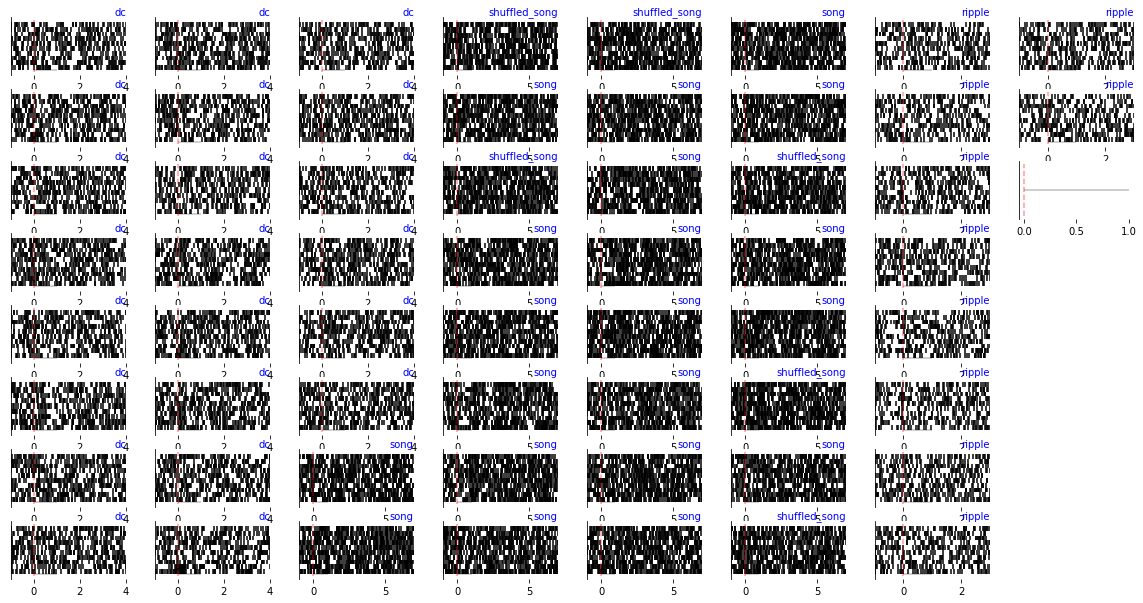

e19u0sRedBla0907M_191219_091547
Quartile: 0.25
SI = 0.13


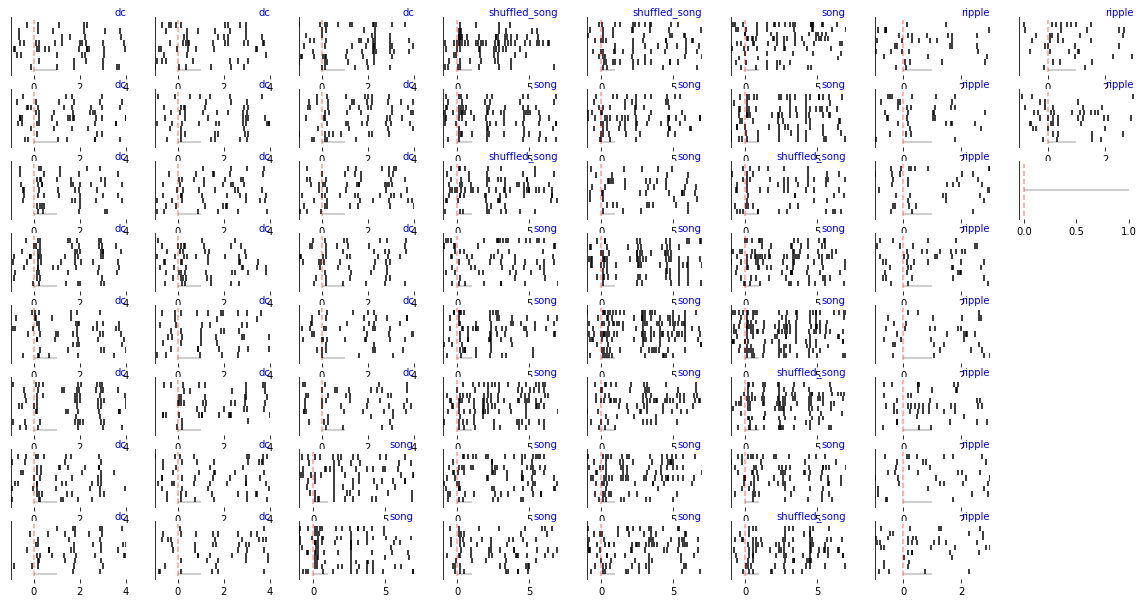

e22u0sGreBla7410M_200116_102111
Quartile: 0.50
SI = 0.23


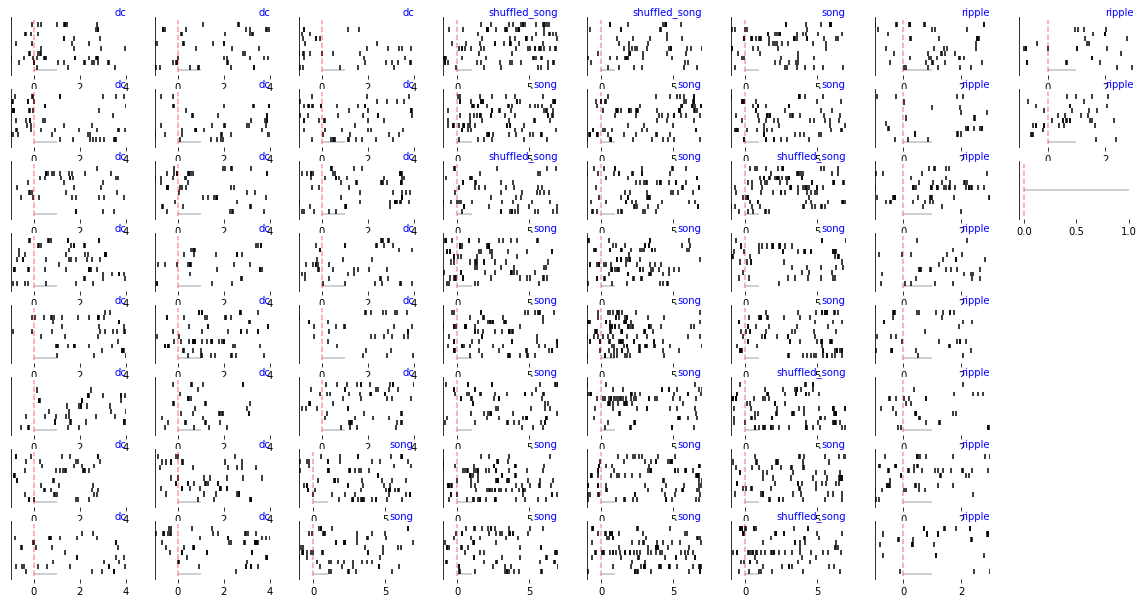

e24u25sRedBla0907M_191219_150159
Quartile: 0.75
SI = 0.38


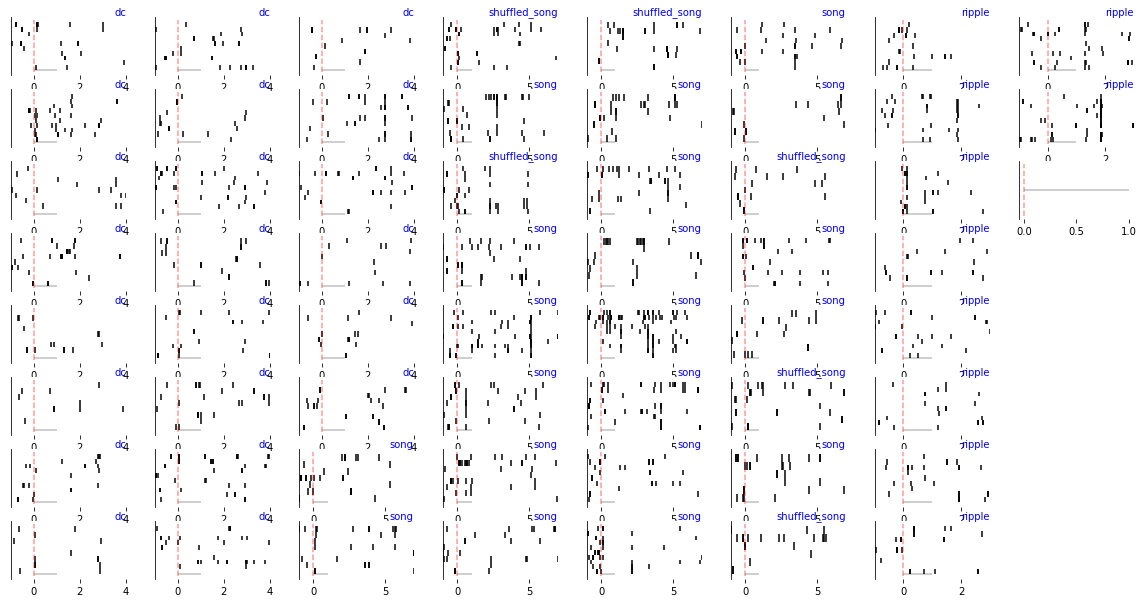

e6u22sGreBla7410M_200116_075450
Quartile: 1.00
SI = 0.73


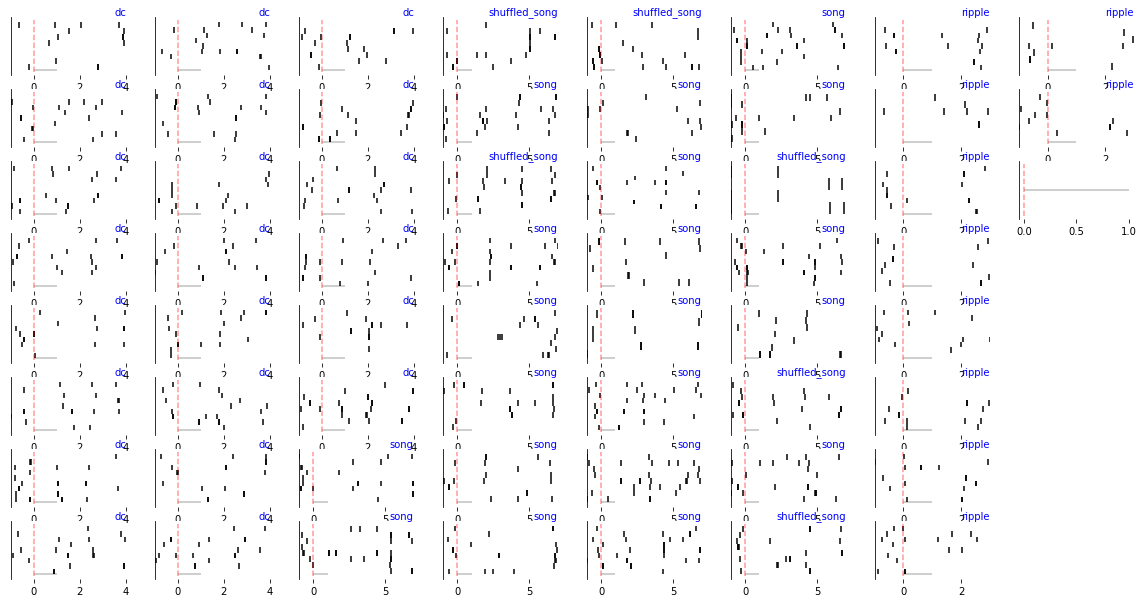

In [20]:
for quartile in [0, 0.25, 0.5, 0.75, 1]:
    # plot an example unit at that quartile of selectivity
    if quartile == 1:
        idx = selectivity_ranked[-1]
    else:
        idx = selectivity_ranked[int(np.round(quartile * len(good_units)))]

    row = good_units.iloc[idx]
    unit_id = row.name
    example_df = ephys_data.query("unit_id == '{}'".format(unit_id))
    
    print(unit_id)
    print("Quartile: {:.2f}".format(quartile))
    print("SI = {:.2f}".format(np.max(selectivity_results[idx]["all"]["rate"])))
    fig, axes = plot_all_responses(example_df)
    plt.show()
    plt.close(fig)

In [21]:
selectivity_ranked = np.arange(len(good_units))[np.argsort([np.max(r["all"]["max_response"]) for r in selectivity_results])]

e22u10sGreBla7410M_200116_113558
Quartile: 0.00
SI = 0.01


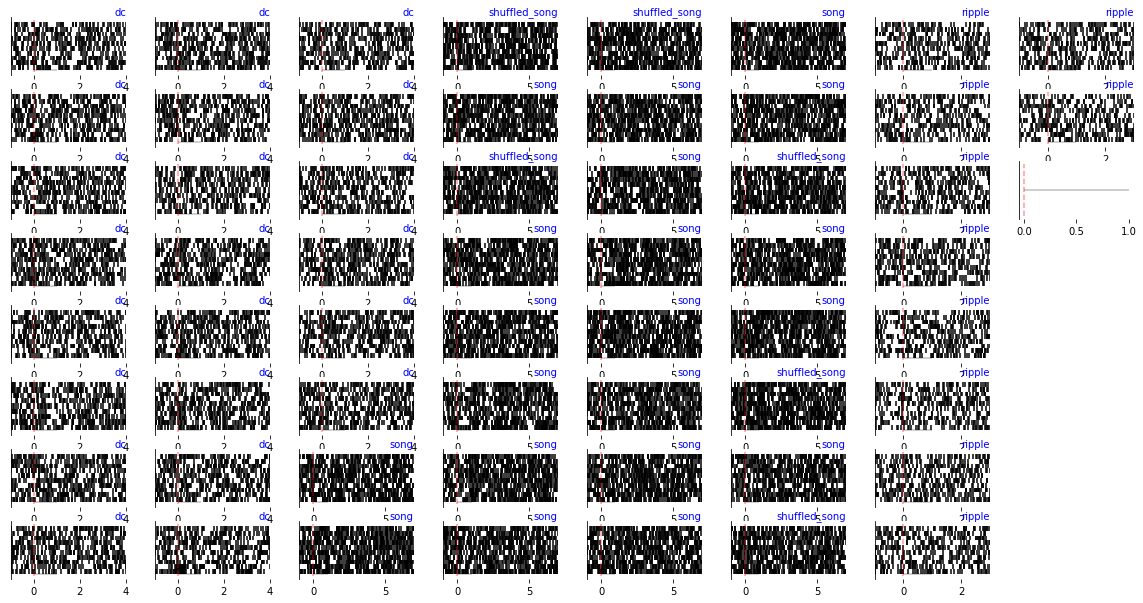

e12u3sGreBla5671F_200117_112217
Quartile: 0.25
SI = 0.05


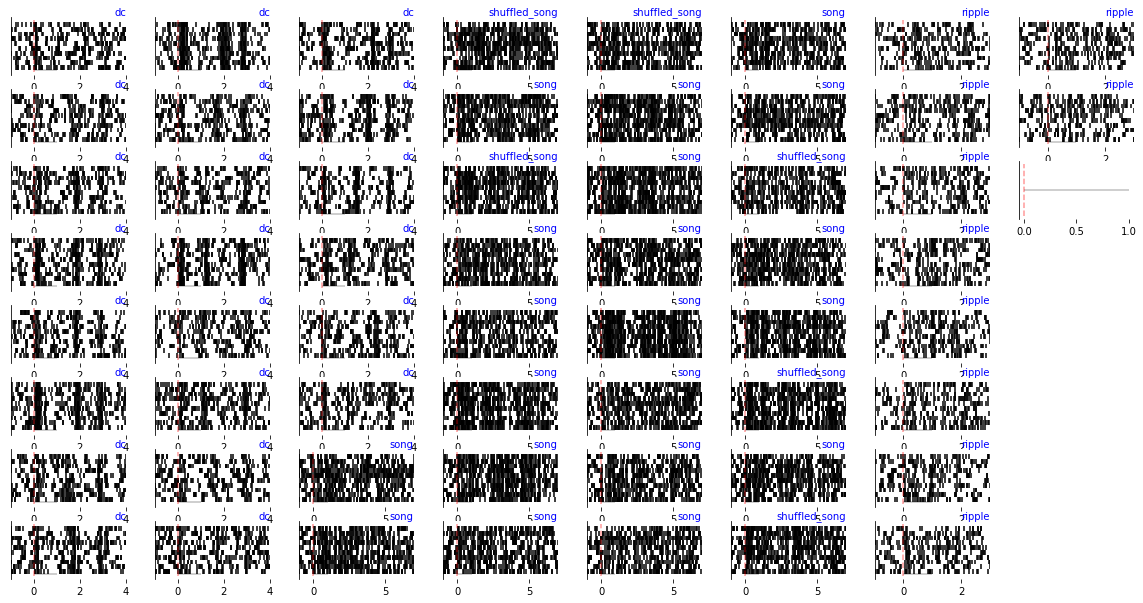

e16u27sGreBla7410M_200116_163016
Quartile: 0.50
SI = 0.09


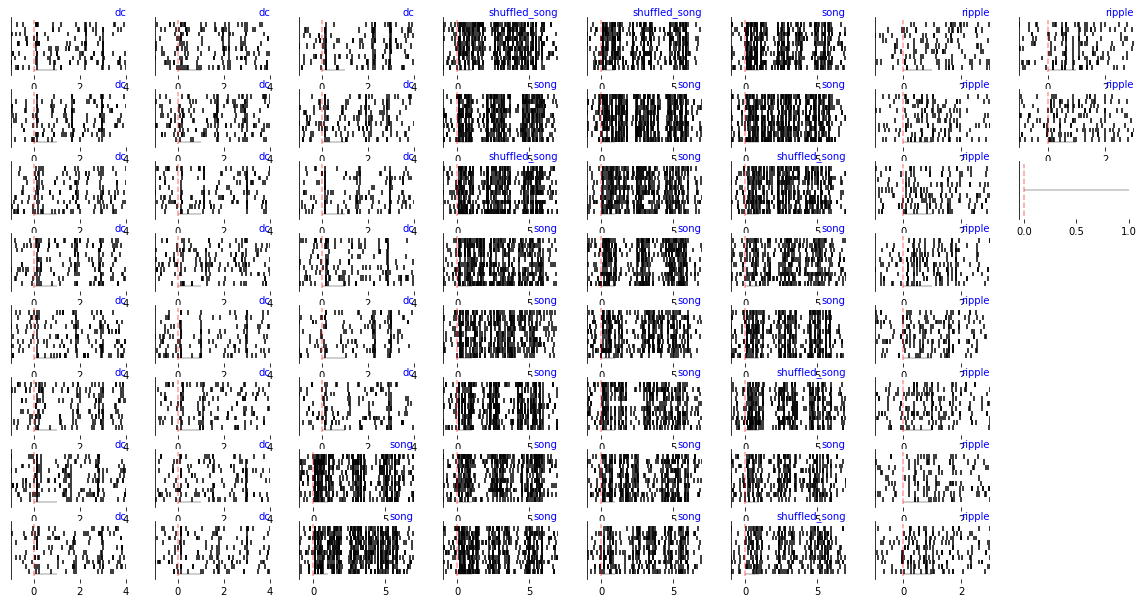

e18u59sGreBla5671F_200117_160922
Quartile: 0.75
SI = 0.14


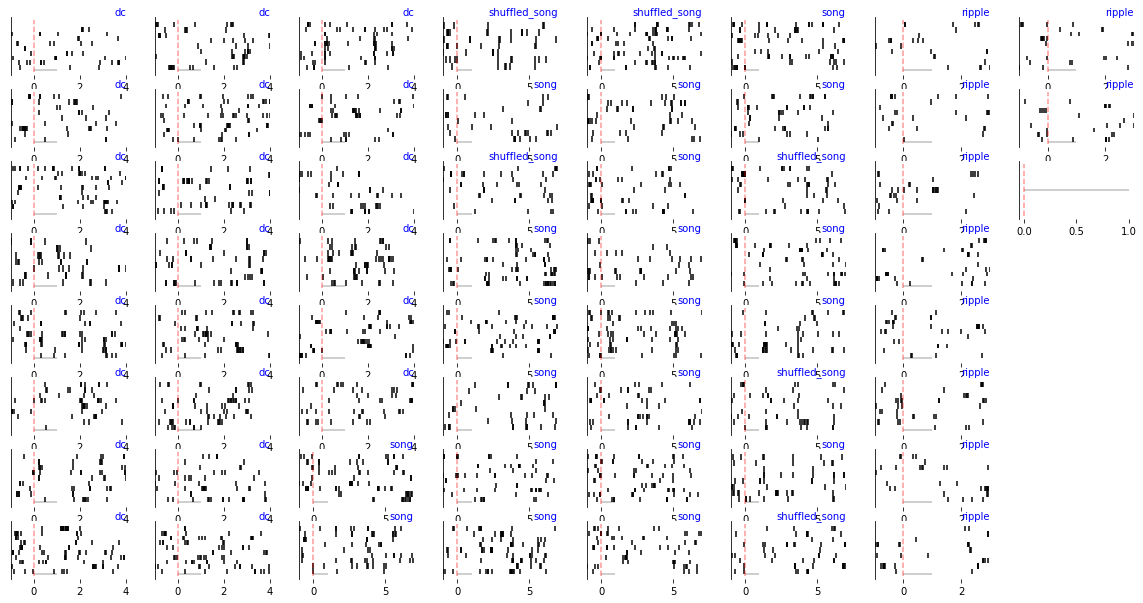

e11u2sGreBla5671F_200117_145748
Quartile: 1.00
SI = 0.47


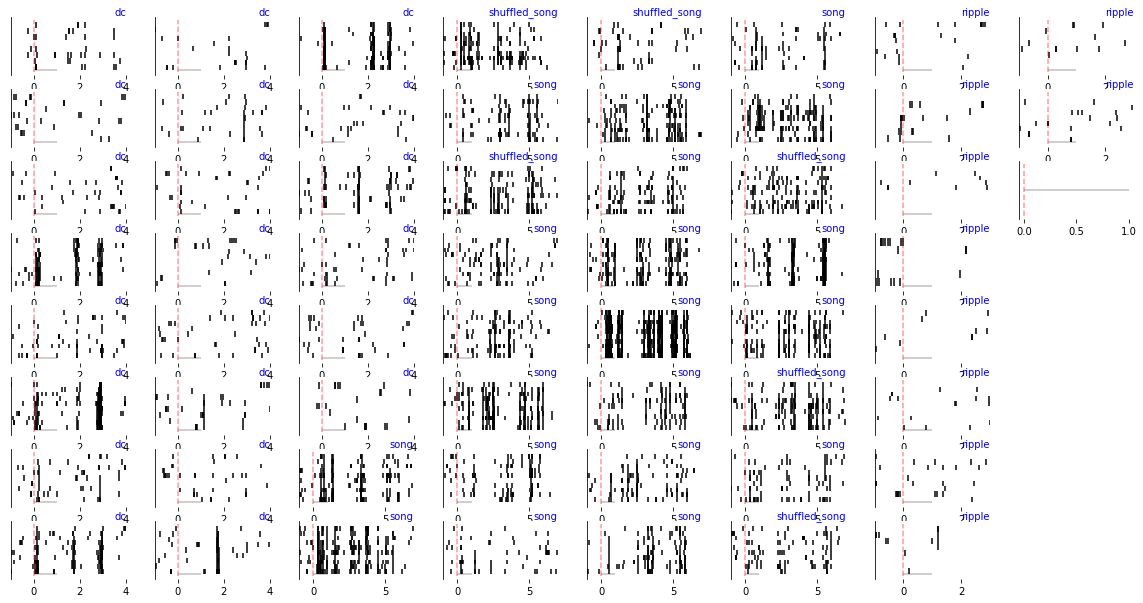

In [22]:
for quartile in [0, 0.25, 0.5, 0.75, 1]:
    # plot an example unit at that quartile of selectivity
    if quartile == 1:
        idx = selectivity_ranked[-1]
    else:
        idx = selectivity_ranked[int(np.round(quartile * len(good_units)))]

    row = good_units.iloc[idx]
    unit_id = row.name
    example_df = ephys_data.query("unit_id == '{}'".format(unit_id))
    
    print(unit_id)
    print("Quartile: {:.2f}".format(quartile))
    print("SI = {:.2f}".format(np.max(selectivity_results[idx]["all"]["max_response"])))
    fig, axes = plot_all_responses(example_df)
    plt.show()
    plt.close(fig)

### Export data for EPHYS8


In [23]:
export_good_units = good_units.copy()

In [24]:
export_good_units["selectivity_results"] = pd.Series([x for x in selectivity_results], index=export_good_units.index)
export_good_units[["selectivity_results"]].to_pickle("../data/ephys/selectivity_export.pkl")